In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from numpy.core.arrayprint import repr_format
import functools, copy

In [2]:
# constants
SQRT_2 = np.sqrt(2)

In [3]:
import numpy as np
import cv2 as cv
from numpy.core.arrayprint import repr_format
import functools, copy

SQRT_2 = np.sqrt(2)

class HaarFeature:
    def __init__(self, r1, r2, padding) -> None:
        self.r_inner = r1
        self.r_outer = r2
        self.padding = padding

        count_inner = self.r_inner ** 2
        count_outer = self.r_outer ** 2 - self.r_inner ** 2
        self.val_inner = 1.0 / (self.r_inner / self.r_outer)
        self.val_outer = -self.val_inner * count_inner / count_outer

# roi: y0 x0 y1 x1
def getROI(src, roi, dst=None):
    x0 = 0
    y0 = 0
    y1 = src.shape[0]
    x1 = src.shape[1]
    if roi[0] < 0 or roi[1] < 0 or roi[2] > src.shape[0] or roi[3] > src.shape[1]:
        dst = copy.deepcopy(src)
        if roi[0] < 0:
            y0 = -roi[0]
        if roi[1] < 0:
            x0 = -roi[1]
        if roi[2] > src.shape[1]:
            y1 = roi[2]
        if roi[3] > src.shape[0]:
            x1 = roi[3]
        dst = cv.copyMakeBorder(dst, -y0, y1, -x0, x1, cv.BORDER_REPLICATE)
    else: dst = src[y0:y1, x0:x1, :]
    return dst
        

def findPupilEllipse(img: np.ndarray, pupilParams, out):
    padding = 2 * pupilParams.r_max
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # expand img to allow haar kernel to scan all edges without out-of-bound cases.
    imgPad = cv.copyMakeBorder(gray, padding, padding, padding, padding, cv.BORDER_REPLICATE)
    integral = cv.integral(imgPad)

    haarRadius = 0
    rstep = 2
    ystep = 4
    xstep = 4

    minResponse = np.Infinity
    minValPoint = []
    minValIn = [minResponse, minValPoint]
    minValOut = copy.deepcopy(minValIn)
    pHaarPupil = ()

    # for each iteration of ellipse with radius r,
    # calculate the sums of inner and outer areas of the haar feature
    for r in range(pupilParams.r_min, pupilParams.r_max, rstep):
        r_inner = r
        r_outer = 3*r
        hf = HaarFeature(r_inner, r_outer, padding)

        # **unoptimized**
        for i in range(0, (img.shape[0] - r - r -1)//ystep + 1, ((img.shape[0] - r - r - 1)//ystep + 1) // 8):
            for y in range(i, r + i*ystep, ystep):
                # original illustration of haar kernel and corresponding points, too good not to copy.
                # row1_outer.|         |  p00._____________________.p01
                #            |         |     |         Haar kernel |
                #            |         |     |                     |
                # row1_inner.|         |     |   p00._______.p01   |
                #            |-padding-|     |      |       |      |
                #            |         |     |      | (x,y) |      |
                # row2_inner.|         |     |      |_______|      |
                #            |         |     |   p10'       'p11   |
                #            |         |     |                     |
                # row2_outer.|         |     |_____________________|
                #            |         |  p10'                     'p11

                upper_inner = integral[y + padding - r_inner]
                lower_inner = integral[y + padding + r_inner + 1]
                upper_outer = integral[y + padding - r_outer]
                lower_outer = integral[y + padding + r_outer + 1]

                p00_inner = upper_inner[r + padding - r_inner]
                p01_inner = upper_inner[r + padding + r_inner + 1]
                p10_inner = lower_inner[r + padding - r_inner]
                p11_inner = lower_outer[r + padding + r_inner + 1]

                p00_outer = upper_outer[r + padding - r_outer]
                p01_outer = upper_outer[r + padding + r_outer + 1]
                p10_outer = lower_outer[r + padding - r_outer]
                p11_outer = lower_outer[r + padding + r_outer + 1]
                
                for x in range(r, img.shape[1] - r, xstep):
                    sumInner = p00_inner + p11_inner - p01_inner - p10_inner
                    sumOuter = p00_outer + p11_outer - p01_outer - p10_outer

                    response = hf.val_inner * sumInner + hf.val_outer * sumOuter

                    if (response < minResponse):
                        minValOut[0] = response
                        minValOut[1] = (x, y)
                    
                    p00_inner += xstep
                    p01_inner += xstep
                    p10_inner += xstep
                    p11_inner += xstep

                    p00_outer += xstep
                    p01_outer += xstep
                    p10_outer += xstep
                    p11_outer += xstep

        if (minValOut[0] < minResponse):
            minResponse = minValOut[0]
            pHaarPupil = minValOut[1]
            haarRadius = r
            print(minResponse)
    
    haarRadius = (int)(haarRadius * SQRT_2)

    roiHaarPupil = (pHaarPupil[0]-r, pHaarPupil[1]-r, pHaarPupil[0]+r, pHaarPupil[1]+r) # y0 x0 y1 x1
    mHaarPupil = getROI(img, roiHaarPupil)

    # calculate histogram of pupil
    hist = cv.calcHist(mHaarPupil, [1], None, [256], (0, 256))

    # temp return
    return (roiHaarPupil, mHaarPupil, hist, minValOut)


In [14]:
# capture one frame for sample
cap = cv.VideoCapture(0)
_, frame = cap.read()
cap.release()

In [17]:
class pupilParams:
    def __init__(self):
        self.r_min = 5
        self.r_max = 10
    
    def setparam(self, min, max):
        self.r_max = max
        self.r_min = min

pp = pupilParams()
roiHaarPupil, mHaarPupil, hist, minRes = findPupilEllipse(frame, pp, None)

73816.875
65928.375


In [15]:
padding = 2 * 10
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
# expand img to allow haar kernel to scan all edges without out-of-bound cases.
imgPad = cv.copyMakeBorder(gray, padding, padding, padding, padding, cv.BORDER_REPLICATE)
integral = cv.integral(imgPad)

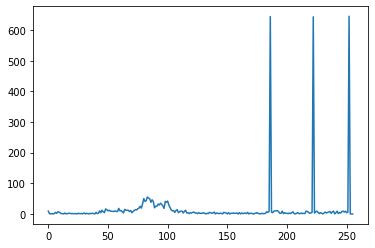

In [7]:
plt.plot(hist)

In [18]:
marked = cv.circle(frame, minRes[1], 2, (100, 0, 255), thickness=3)
cv.imshow('mhaarpupil', mHaarPupil)
cv.imshow('img', marked)
cv.imshow('padded', imgPad)
while(1):
    if cv.waitKey(1) == 27:
        break
cv.destroyAllWindows()

In [9]:
integral.shape, frame.shape

((481, 641), (480, 640, 3))

In [10]:
roiHaarPupil, minRes

((620, 315, 638, 333), [153870.375, (629, 324)])